***
**Algorithmes d'optimisation -- L3 MINT et doubles licences -- Université Paris-Sud**
***

$\newcommand{\Rsp}{\mathbb{R}}
\newcommand{\nr}[1]{\|#1\|}
\newcommand{\abs}[1]{|#1|}
\newcommand{\eps}{\varepsilon}
\newcommand{\sca}[2]{\langle#1|#2\rangle}
\newcommand{\D}{\mathrm{D}}
\newcommand{\hdots}{\dots}
\newcommand{\cond}{\mathrm{cond}}$

# TP 2: Régression logistique

## Partie I: Descente de gradient avec rebroussement d'Armijo ##

Étant donné un point $x^{(k)}$ et une direction de descente $d^{(k)}$ le pas d'Armijo est défini de la manière suivante: 

$$ t^{(k)}_{\mathrm{arm}} = \max \left\{ t  \mid t = \beta^\ell, \ell\in \mathbb{N}, \hbox{ tq } f(x^{(k)} + t d^{(k)}) \leq f(x) + \alpha t\sca{\nabla f(x)}{d^{(k)}} \right\}, $$

où on prendra $\alpha = 0.3, \beta = 0.5$. Algorithmiquement, on procède de la manière suivante pour calculer $t^{(k)}_{\mathrm{arm}}$ en fonction de $x=x^{(k)}$ et $v = d^{(k)}$:

$$
\left|
\begin{aligned}
&\mathrm{pas\_armijo}(f,x,v)\\
&\qquad t \gets 1\\
&\qquad m \gets \sca{\nabla f(x)}{v}\\
&\qquad \textbf{while } f(x + t v) > f(x) + \alpha t m \\
&\qquad\qquad t \gets \beta t\\
&\qquad \mathrm{return}~t
\end{aligned}\right.
$$

L'algorithme de descente de gradient avec rebroussement d'Armijo s'écrit alors de la manière suivante:

$$
\begin{cases}
d^{(k)} = - \nabla f(x^{(k)}) \\
t^{(k)} = \mathrm{pas\_armijo}(f,x^{(k)}, d^{(k)})\\
x^{(k+1)} = x^{(k)} + t^{(k)} d^{(k)}
\end{cases}$$


**QI.1**)  Écrire les fonctions suivantes:
- `pas_armijo(f,gradf,x)` prend en entrée $f:\Rsp^N\to\Rsp$, `gradf`$=\nabla f:\Rsp^N\to\Rsp^N$, $x,d\in\Rsp^N$. On choisira `alpha`$=0.3$, `beta`$=0.5$ et on retournera le pas $t$. 
- `gradient_armijo(f,gradf,x0,err=1e-6,maxiter=1000)` prenant en argument la fonction `f`, `gradf`, `x0`=$x^{(0)}$ et un critère d'arrêt `err`$\in\Rsp$, et qui effectue l'algorithme de descente de gradient avec pas d'Armijo en arrêtant la boucle dès que $\nr{d^{(k)}} \leq$ `err` où dès que $k\geq$ `maxiter`. Cette fonction retournera le point $x$ trouvé, un vecteur contenant la suite  $f(x^{(k)})$ et un second vecteur contenant $\nr{\nabla f(x^{(k)})}$. Indications:
    - **Pour la fonction gradient_armijo, ne pas hésiter à copier-coller gradient_optimal et à faire les modifications nécessaires**
    - **Ne stocker que l'itération courante et pas la suite des itérées**

In [48]:
# on importe les modules numpy et pyplot
import numpy as np
import matplotlib.pyplot as plt
# les deux commandes suivante paramètrent l'affichage des figures
%matplotlib inline
plt.rcParams['figure.figsize'] = [9.,6.]

# les paramètres alpha et beta comportent une valeur par défaut, c'est-à-dire que 
# pas_armijo(f,x,d,m) est équivalent à pas_armijo(f,x,d,m,0.3,0.5)
def pas_armijo(f, gradf, x, v, alpha = 0.3, beta = 0.5):
    t = 1
    m = gradf(x).dot(v)
    while(f(x + t*v) > f(x) + alpha * t * m):
        t *= beta 
    return t
    
# la descente de gradient prend en argument:
# f = la fonction à évaluer
# gradf = le gradient de f
# x0 = le point de départ
def gradient_armijo(f,gradf,x0,err=1e-6,maxiter=1000):
    x = x0 
    resF = []
    normF = []
    for _ in range(maxiter):
        resF.append(f(x))
        normF.append(np.linalg.norm(gradf(x)))
        d = -gradf(x)
        t = pas_armijo(f, gradf, x, d)
        x = x + t*d 
        if(np.linalg.norm(d) <= err):
            break 

    return x, resF, normF

**QI.2**) Tester la fonction `gradient_armijo` en dimension $N=1$, $f(x) = x^{2} + e^{x}$, $x_0 = 1$ et en prenant pour critère d'arrêt `err`$= 10^{-8}$. Vous devriez trouver $x^* = -0.3517...$. 

In [49]:
f = lambda x: x**2 + np.exp(x)
gradf = lambda x: 2*x + np.exp(x)
x0 = np.array([1])

x, _, _ = gradient_armijo(f, gradf, x0, err = 1e-8)
print(f"La valeur de x* trouvée est : {x[0]:.5f} ") 

La valeur de x* trouvée est : -0.35173 


## Partie II: Régression logistique avec rebroussement d'Armijo en dimension $N=2$

L'explication de la méthode est à lire dans la feuille de TD.
On commence par construire les données $(x_a)_{a \in A} \subseteq \Rsp^2$ où :
- $A = \{1,\hdots,n\} = A_0\sqcup A_1$, $A_0 = \{0, \hdots, m-1,\}$, $A_1 = \{m, 2m-1\}$, $n = 2m$
- Les points $(x_a)_{a\in A_0}$ sont tirés selon une gaussienne centrée en $(0.5,0.5)$
- Les points $(x_a)_{a\in A_1}$ sont tirés selon une gaussienne centrée en $(-0.5,-0.5)$.

On cherche alors à construire, par optimisation de la fonction $F$, un vecteur $w\in\Rsp^2$ tel
que $\sigma(\sca{w}{x_a}) \simeq 0$ si $a\in A_0$ et  $\sigma(\sca{w}{x_a})\simeq 1$ si $a\in A_1$.

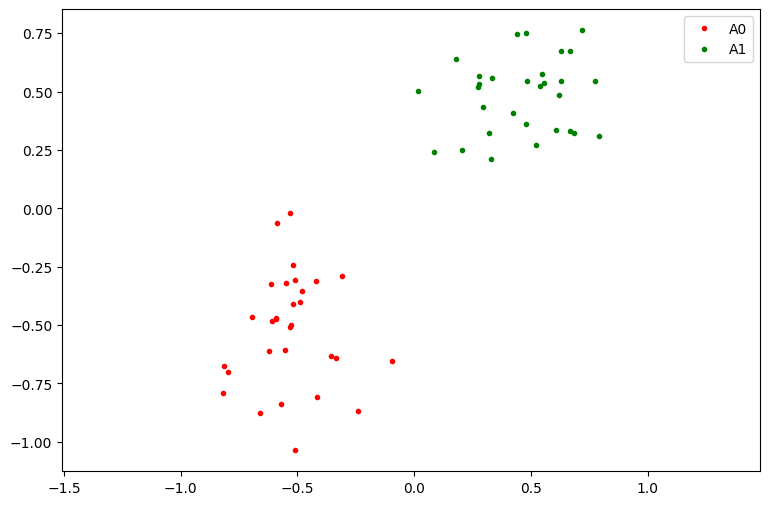

In [66]:
m = 30
n = 2*m
X = np.vstack((np.hstack((-0.5+.2*np.random.randn(m,1), -0.5 + .2*np.random.randn(m,1))),
               np.hstack((0.5+.2*np.random.randn(m,1), 0.5 + .2*np.random.randn(m,1)))))
A0 = range(0,m)
A1 = range(m,2*m)
plt.plot(X[A0,0],X[A0,1],'.r',label='A0')
plt.plot(X[A1,0],X[A1,1],'.g',label='A1')
plt.legend()
plt.axis('equal');

**QII.1**: Écrire deux fonctions `F(w,X,A0,A1,gamma)` et `gradF(w,X,A0,A1,\gamma)` calculant la valeur et le gradient de la fonctionnelle 

$$ F(w) = - \left(\sum_{a\in A_0} \log(1-\sigma(\sca{w}{x_a})) + \sum_{a\in A_1} \log(\sigma(\sca{w}{x_a})\right) + \frac{\gamma}{2} \nr{w}^2. $$

Tester que `gradF` correspond bien au gradient de `F` en utilisant la fonction `verifier_gradient` fournie ci-dessous.

erreur numérique dans le calcul du gradient: 1.22851e-10 (doit être petit)


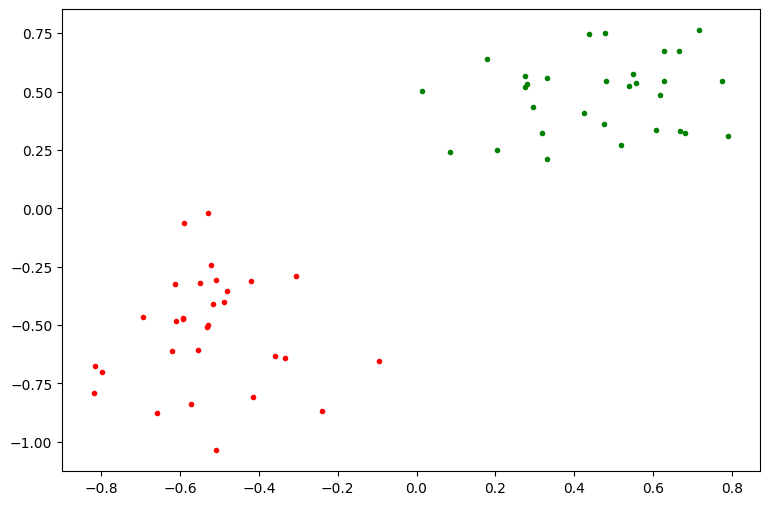

In [67]:
# on définit une fonction sigma(t) correspondant à la sigmoïde
def sigma(t):
    return np.exp(t) / (1 + np.exp(t))

def F(w,X,A0,A1,gamma):
    fA0 = np.sum([np.log(1 - sigma(w.dot(x))) for x in X[A0,:]])
    fA1 = np.sum([np.log(sigma(w.dot(x))) for x in X[A1,:]])

    return -(fA0 + fA1) + gamma/2 * w.dot(w)

plt.plot(X[A0,0],X[A0,1],'.r',label='A0')
plt.plot(X[A1,0],X[A1,1],'.g',label='A1')
        
def gradF(w,X,A0,A1,gamma):
    res = np.zeros((len(w)))
    for i in A0:
        x = X[i]
        res = res + sigma(w.dot(x)) * x

    for i in A1:
        x = X[i]
        res = res + (sigma(w.dot(x)) -1) * x

    return res + gamma * w

def verifier_gradient(f,gradf,x0):
    N = len(x0)
    gg = np.zeros(N)
    for i in range(N):
        eps = 1e-5
        e = np.zeros(N)
        e[i] = eps
        gg[i] = (f(x0+e) - f(x0-e))/(2*eps)
    print('erreur numérique dans le calcul du gradient: %g (doit être petit)' % np.linalg.norm(gradf(x0)-gg))
    
# on vérifie l'implémentation de gradF en utilisant la fonction verifier_gradient
gamma = .1
f = lambda w: F(w,X,A0,A1,gamma)
gradf = lambda w: gradF(w,X,A0,A1,gamma)
verifier_gradient(f, gradf, np.random.rand(2))

**QI.2**: Calculer $w=\arg\min_{\Rsp^2} F$ en utilisant la fonction gradient_armijo. Tracer sur un graphe l'évolution de la norme du gradient au cours des itérations de la descente de gradient, soit $(k,\nr{\nabla F(w^{(k)})})$, où l'axe $y$ sera en échelle logarithmique.

In [68]:
Flog = lambda w:F(w, X, A0, A1, gamma)
gradFlog = lambda w:gradF(w, X, A0, A1, gamma)

w, resF, normF = gradient_armijo(Flog, gradFlog, np.random.random(size = 2)) 

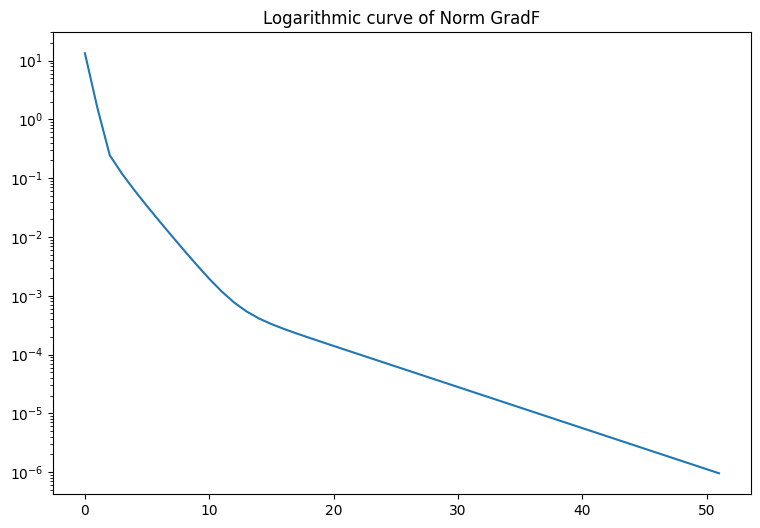

In [69]:
plt.title("Logarithmic curve of Norm GradF")
plt.semilogy(normF)

**QI.3**: Soit $w$ le minimiseur approché de $F$ calculé dans la question précédente. Tracer sur un graphe:
- les points $(x_a)_{a\in A_0}$ en rouge
- les points $(x_a)_{a\in A_1}$ en bleu
- quelques lignes de niveau de la fonction $u:x\mapsto \sigma(\sca{w}{x})$ en utilisant la fonction fournie `afficher_lignes_niveau(w)`.

Faire varier le paramètre de régularisation $\gamma \in \{0.01,0.1,1,10\}$ et observer:
- comment varie le nombre d'itérations.
- comment varie $\nr{w}$ (où $\nr{w}$ est le minimiseur).
- quel est l'effet sur la fonction $u:x\mapsto \sigma(\sca{w}{x_i})$.

<!--
%On peut expliquer le premier point en se rappelant que
%Si on note $F_\gamma$ la fonction avec le paramètre $\gamma$, montrer que pour $\gamma' \geq \gamma$ on a 
%$$ \forall w\in\Rsp^d,\forall v\in \Rsp^d, \sca{D^2 F_\gamma(w)v}{v} \leq \sca{D^2 F_{\gamma'}(w)v}{v} $$
%En déduire que si $m \leq \D^2 F_\gamma \leq M$ sur $S\subseteq \Rsp^d$, alors 
%$$ m+(\gamma'-\gamma) \leq \D^2 F_\gamma \leq M + \gamma'-\gamma $$
%, en notant $\lambda_1(A) < \hdots \leq \lambda_d(A)$ les valeurs propres de $A$,
%$$ \frac{\lambda_d(A')}{\lambda_1(A')} \leq \frac{\lambda_d(A)}{\lambda_1(A)} $$
$$
-->

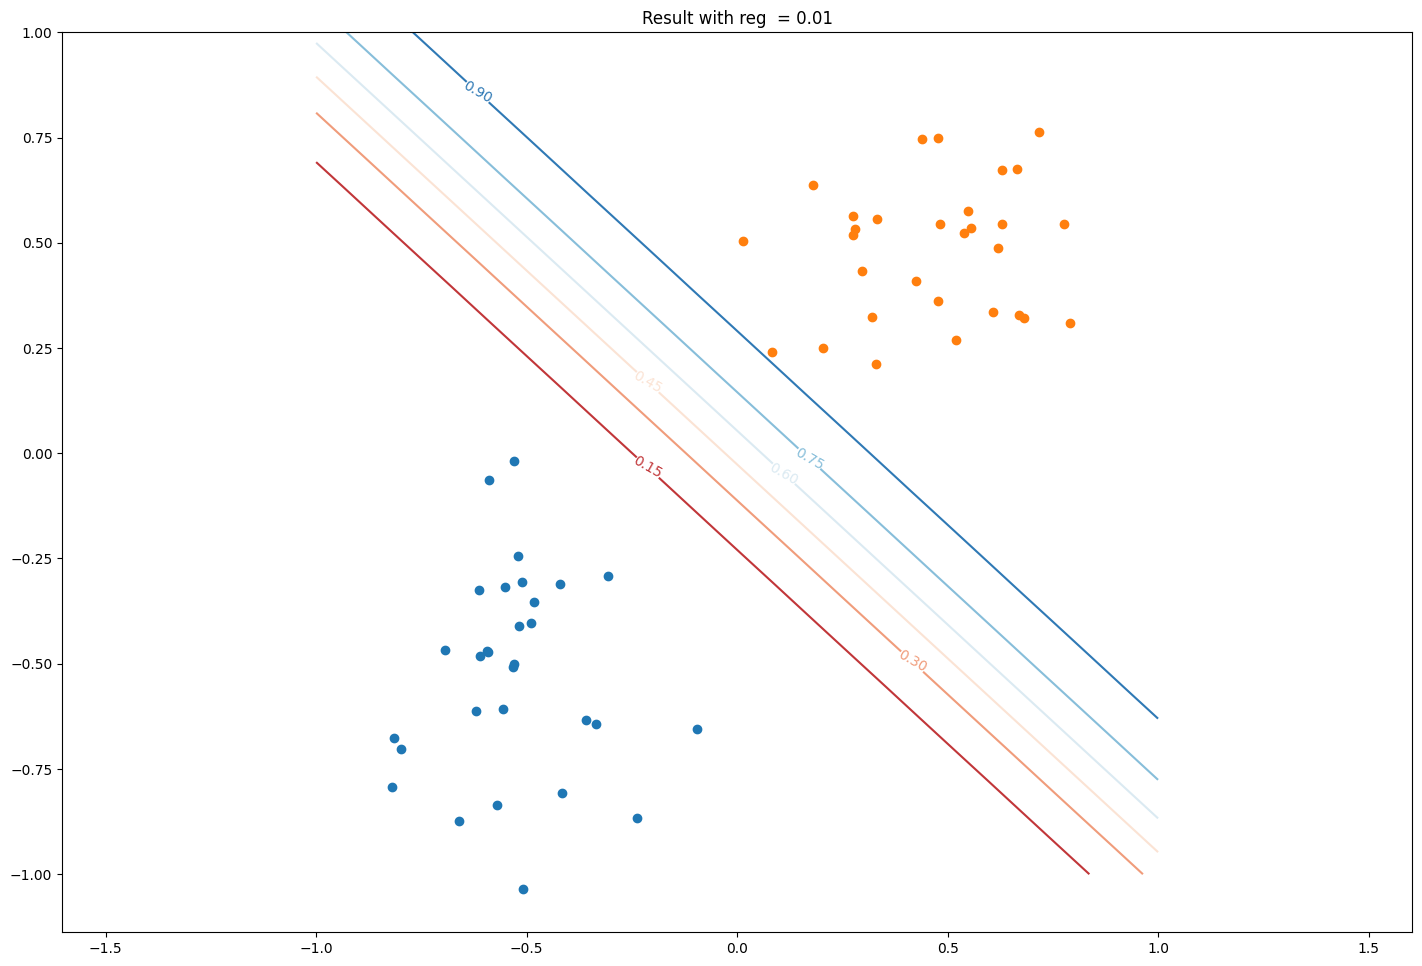

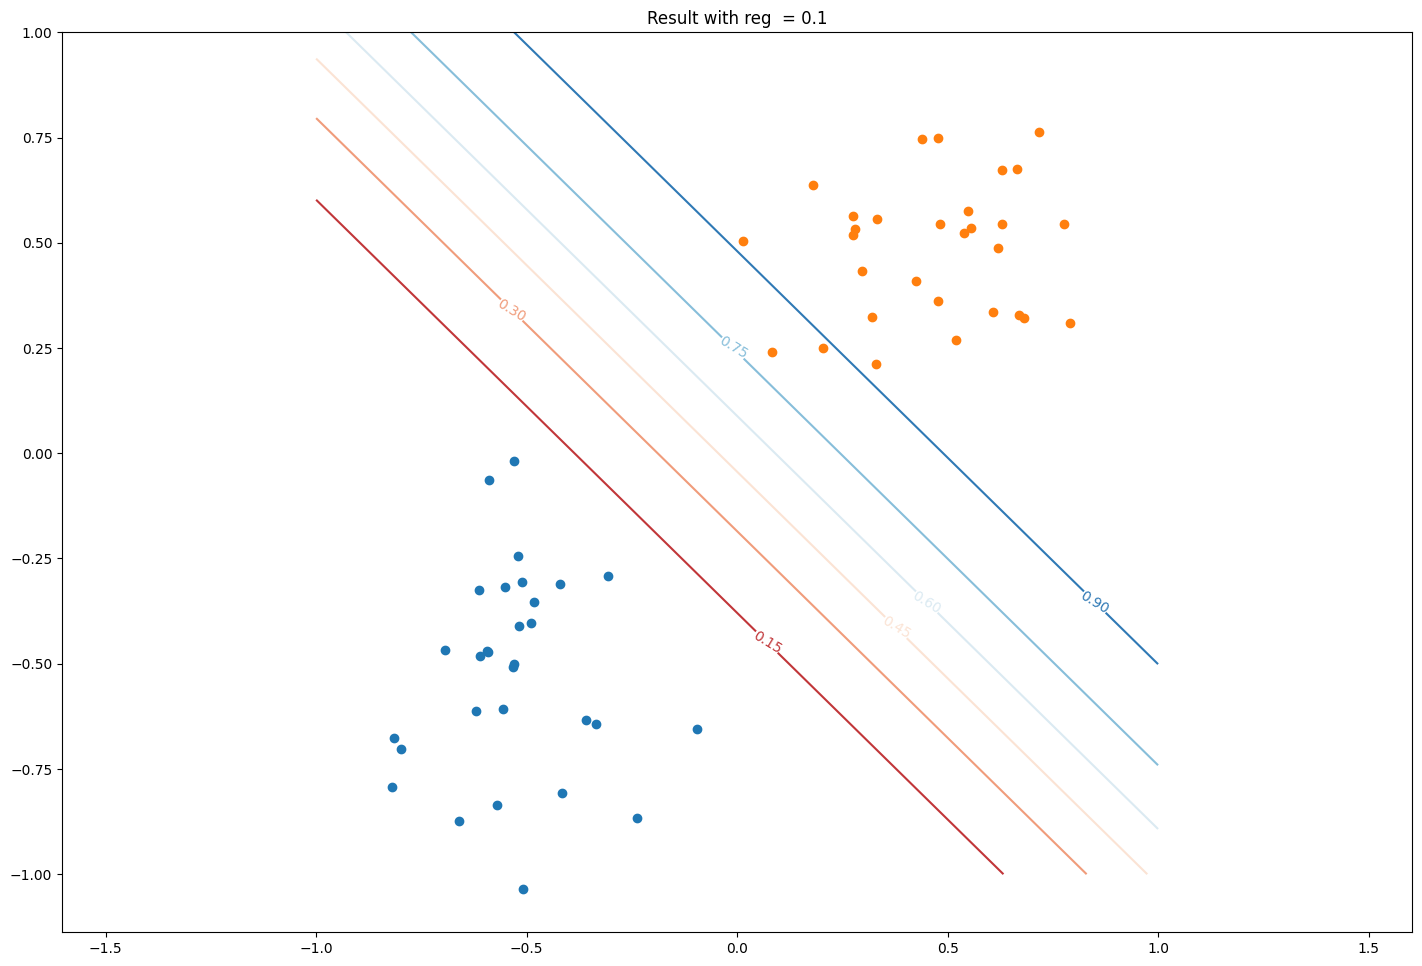

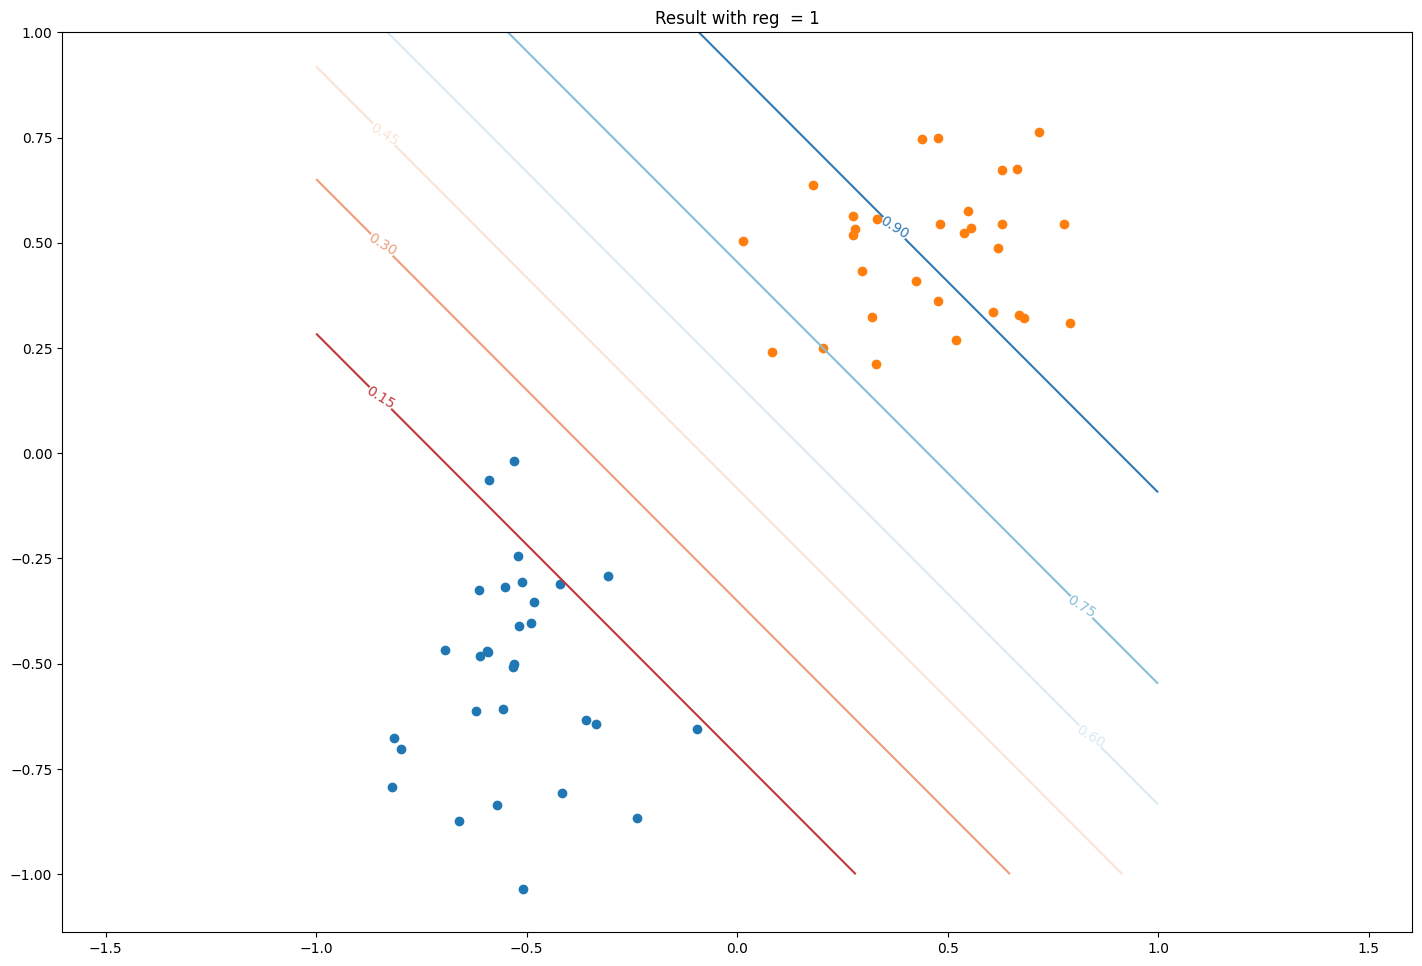

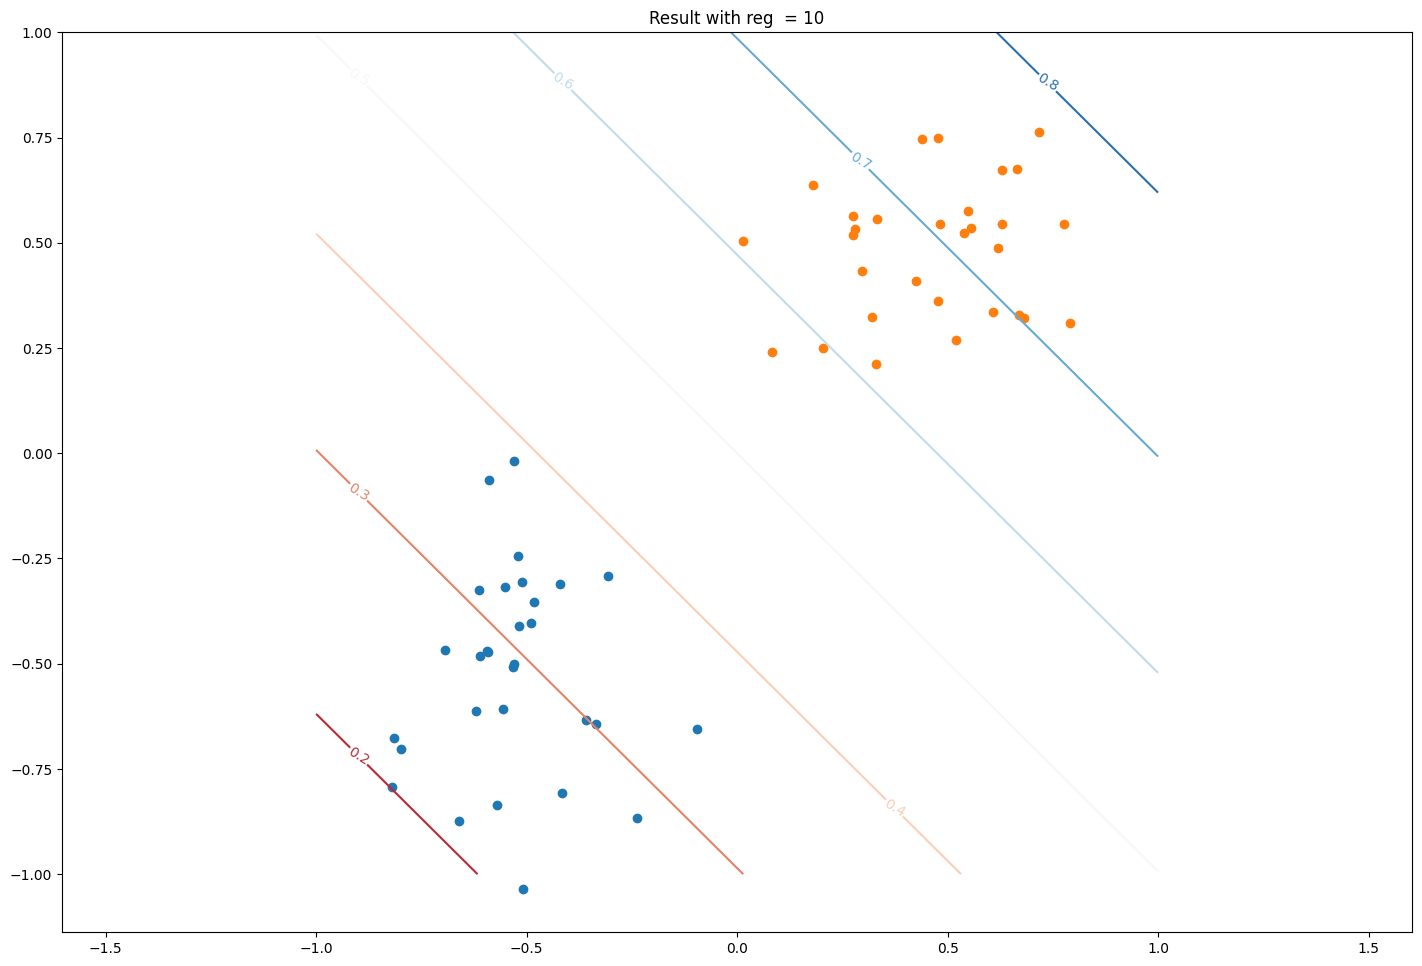

In [70]:
# on définit une fonction permettant d'afficher les lignes de niveaux de u_w: R^2 -> R
# definie par u_w(x) = \sigma(<x|w>)
# NB: u peut être définie en utilisant lambda, par exemple:
#    u = lambda (x,y): ... où x,y sont les coordonnées du point
def afficher_lignes_niveau(w):
    Xcontour,Ycontour = np.meshgrid(np.linspace(-1., 1., 100),
                                    np.linspace(-1., 1., 100))
    u = lambda x,y: sigma(x*w[0] + y*w[1])
    Zcontour = u(Xcontour,Ycontour)
    plt.axes([-1.5, -1.5, 1.5, 1.5])
    plt.axis('equal')
    p = plt.contour(Xcontour, Ycontour, Zcontour, cmap='RdBu')

    plt.scatter(X[A0,0],  X[A0,1])
    plt.scatter(X[A1,0],  X[A1,1])

    plt.clabel(p, inline=1, fontsize=10)
    plt.title(f"Result with reg  = {gamma}")
    plt.show()

for gamma in [0.01, 0.1, 1, 10]:
    Flog = lambda w:F(w, X, A0, A1, gamma)
    gradFlog = lambda w:gradF(w, X, A0, A1, gamma)

    w, resF, normF = gradient_armijo(Flog, gradFlog, np.random.random(size = 2)) 
    
    afficher_lignes_niveau(w)

## Partie III: Régression logistique avec méthode de Newton en dimension $N=2$

**QIII.1**: Écrire une fonction `hessF` calculant la hessienne de $F$, en utilisant la formule obtenue en TD. Vérifier le bon fonctionnement de `hessF` via la fonction `verifier_hessienne` fournie ci-dessous.

In [71]:
""" cette fonction vérifie numériquement que hessf (=fonction évaluant la hessienne de f) est bien
    la dérivée de grad (= fonction évaluant le gradient de f), en un point x0 """
def verifier_hessienne(gradf,hessf,x0):
    N = len(x0)
    H = np.zeros((N,N))
    for i in range(N):
        eps = 1e-5
        e = np.zeros(N)
        e[i] = eps
        H[i,:] = (gradf(x0+e) - gradf(x0-e))/(2*eps)

    print('erreur numerique dans le calcul de la hessienne: %g (doit etre petit)' % np.sum((H-hessf(x0)))**2)
    
def hessF(w, X, A0, A1, gamma):
    sigmoid_values = sigma(np.dot(X, w))

    S = np.diag(sigmoid_values * (1 - sigmoid_values))
    H = np.dot(np.dot(X.T, S), X)

    return H + gamma * np.eye(H.shape[0])

Flog = lambda w:F(w, X, A0, A1, 0)
gradFlog = lambda w: gradF(w, X, A0, A1, 0)
hessFlog = lambda w: hessF(w, X, A0, A1, 0)

verifier_hessienne(gradFlog, hessFlog, x0 = np.random.random(size = 2))

erreur numerique dans le calcul de la hessienne: 5.56987e-19 (doit etre petit)


**QIII.2**: Écrire une fonction `newton_armijo(f,gradf,hessf,x0,err=1e-6,maxiter=1000)` implémentant la méthode de Newton avec rebroussement d'Armijo, c'est-à-dire l'algorithme suivant:

$$
\begin{cases}
g^{(k)} = \nabla F(x^{(k)}) \\
d^{(k)} = -[D^2 F(x^{(k)})]^{-1} \nabla F(x^{(k)}) \\
t^{(k)} = \mathrm{pas\_armijo}(f,x^{(k)},d^{(k)})\\
x^{(k+1)} = x^{(k)} + t^{(k)} d^{(k)}
\end{cases}
$$

Il ne faut pas hésiter à copier-coller la fonction gradient_armijo et à changer ce qui est nécessaire. Pour la résolution du système linéaire, on utilisera `np.linalg.solve`. 

Utiliser cette fonction pour calculer le minimum de $F$. Comme dans la question Q1.2, tracer la norme du gradient en fonction de l'itération. Vérifier également que le nombre d'itérations dépend peu du choix du paramètre $\gamma$.

gamma=0.01
iteration 1: f=41.588831, |g|=21.167052, step=1.000000
iteration 2: f=9.823753, |g|=5.464198, step=1.000000
iteration 3: f=3.993058, |g|=1.996967, step=1.000000
iteration 4: f=1.857830, |g|=0.738160, step=1.000000
iteration 5: f=1.075612, |g|=0.259183, step=1.000000
iteration 6: f=0.842719, |g|=0.075446, step=1.000000
iteration 7: f=0.805492, |g|=0.012723, step=1.000000
iteration 8: f=0.804078, |g|=0.000533, step=1.000000
iteration 9: f=0.804075, |g|=0.000001, step=1.000000
gamma=0.1
iteration 1: f=41.588831, |g|=21.167052, step=1.000000
iteration 2: f=10.287023, |g|=5.325493, step=1.000000
iteration 3: f=5.070635, |g|=1.797473, step=1.000000
iteration 4: f=3.659672, |g|=0.514565, step=1.000000
iteration 5: f=3.443384, |g|=0.084678, step=1.000000
iteration 6: f=3.435622, |g|=0.003334, step=1.000000
iteration 7: f=3.435609, |g|=0.000006, step=1.000000
gamma=1
iteration 1: f=41.588831, |g|=21.167052, step=1.000000
iteration 2: f=14.220310, |g|=4.158119, step=1.000000
iteration

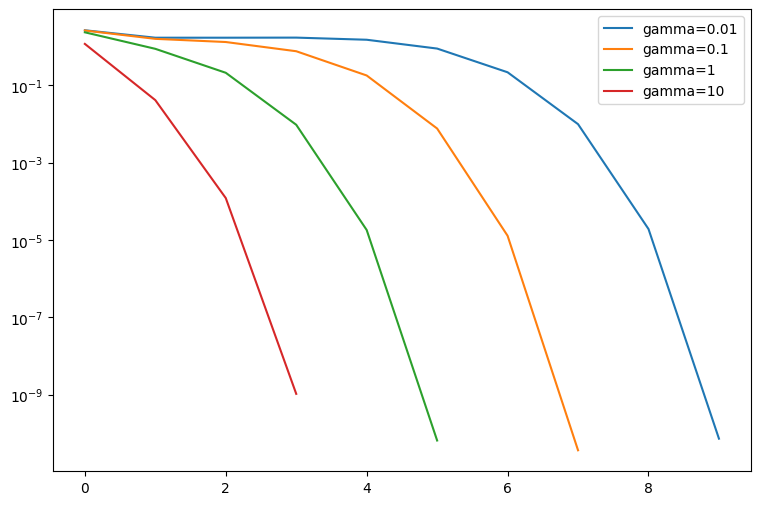

In [72]:
def newton_armijo(f,gradf,hessf,x0,err=1e-6,maxiter=500):
    # la boucle est tres similaire à celle de gradient_armijo: la seule chose qui
    # change est le choix de la direction de descente. 
    # NB: on utilise np.linalg.solve pour résoudre le système linéaire apparaissant dans la méthode
    x = x0.copy()
    fIter = []
    gIter = []
    k = 0
    while(True):
        k = k+1
        if k > maxiter: # maximum de 10^6 itérations
            print('erreur: nombre maximum d\'itérations atteint')
            break
        gx = -gradf(x)
        dx = np.linalg.solve(hessf(x),gx)
        fIter.append(f(x))
        gIter.append(np.linalg.norm(dx))
        if np.abs(np.linalg.norm(gx)) <= err:
            break
        t = pas_armijo(f,gradf,x,dx)
        print('iteration %d: f=%f, |g|=%f, step=%f' % (k, f(x), np.linalg.norm(gx),t))
        x = x + t*dx
    return x,np.array(fIter),np.array(gIter)


for gamma in [0.01,0.1,1,10]:
    w0 = np.zeros(2)
    print("gamma=%g"%gamma)
    w,fiter,giter = newton_armijo(lambda w: F(w,X,A0,A1,gamma),
                                  lambda w: gradF(w,X,A0,A1,gamma),
                                  lambda w: hessF(w,X,A0,A1,gamma), w0, 1e-7, 1000)
    plt.semilogy(giter,label=('gamma=%g'%gamma))
plt.legend()

## Partie IV: Application à la classification de caractères manuscrits

L'objectif de cette partie est d'appliquer la méthode décrite dans les parties précédentes (où l'on traitait des données en dimension $N=2$) à un jeu de données plus réaliste et de dimension beaucoup plus grande. L'objectif est de distinguer des images de caractères manuscrits. Pour cela, on a demandé à 6000 personnes d'écrire les chiffres de zéro à neuf. Ici, l'on cherchera uniqument à distinguer les chiffres zéro manuscrits des chiffres un. Chaque point de donnée $x_a$ est construit de la manière suivante: 

- On demande à une personne d'écrire un chiffre (zéro, un, ..., neuf), que l'on stocke sous la forme d'une image en niveaux de gris de taille 28x28 pixels. On représente cette image par une matrice carrée $p_a \in \mathcal{M}_{28,28}(\Rsp)$ (où $(p_{a})_{ij} = 0$ si le pixel $(i,j)$ est noir et $1$ s'il est blanc). 
- La matrice carrée $p_a \in \mathcal{M}_{28,28}(\Rsp)$ est convertie en un vecteur $x_a\in\Rsp^{N}$ de taille $N = 28\times 28 = 784$. Pour cela, on met bout-à-bout les lignes de la matrice $p$, via la fonction `np.reshape`.
- Enfin, on stocke séparément un entier correspondant au chiffre manuscrit (on appelle ça le "label", ou étiquette, de l'image).

Ce faisant, on obtient donc deux tableaux: 
- `images` possède $60000$ lignes (soit $10$ chiffres zéro, un, $\hdots$ dessinés par $6000$ personnes) et $784=28^2$  colonnes (images de $28\times 28$ pixels stockées sous formes de vecteurs). `images[i]` correspond alors à la $i$ème image, représentée par un vecteur de $\Rsp^{768}$.
- `labels` possède $60000$ lignes et une seule colonne: `label[i]` contient le numéro du chiffre manuscrit représenté par l'image `images[i]`

La fonction `read_mnist()` ci-dessous télécharge ces données et retourne les tableaux `images` et `labels`. On fournit une fonction d'affichage: `show_mnist(images[i])` affiche la $i$ème image.

In [73]:
import os
import struct
import urllib
import gzip
import shutil
try:
    from urllib.request import urlretrieve
except ImportError:
    from urllib import urlretrieve

def gunzip(iname,oname):
    with gzip.open(iname, 'rb') as f_in:
        with open(oname, 'wb') as f_out:
            shutil.copyfileobj(f_in, f_out)
def download_mnist(dest):
    src = 'http://yann.lecun.com/exdb/mnist'
    for f in ['train-images-idx3-ubyte', 'train-labels-idx1-ubyte']:
        urlretrieve('%s/%s.gz' % (src,f), '%s/%s.gz' % (dest,f))
        gunzip('%s/%s.gz' % (dest,f),'%s/%s' % (dest,f))
def read_mnist():
    d = os.path.expanduser('~/.m315-mnist-data')
    if not os.path.isdir(d):
        os.makedirs(d)
        download_mnist(d)
    with open('%s/train-labels-idx1-ubyte' % d, 'rb') as flbl:
        magic, num = struct.unpack(">II", flbl.read(8))
        labels = np.fromfile(flbl, dtype=np.int8)
    with open('%s/train-images-idx3-ubyte' % d, 'rb') as fimg:
        magic, num, rows, cols = struct.unpack(">IIII", fimg.read(16))
        images = np.fromfile(fimg, dtype=np.uint8).reshape(len(labels), rows*cols)/255.
    return images,labels
def show_mnist(image, cmap='gray'):
    plt.figure()
    imgplot = plt.imshow(np.reshape(image,(28,-1)), interpolation='nearest', cmap=cmap)
   
images,labels = read_mnist()

**QIV.0** Passer quelques minutes à jouer avec les fonctions show_mnist() et print() (afficher les labels, et aussi les vecteurs images[i]) pour comprendre le jeu de données.

(784,)
(28, 28)
2


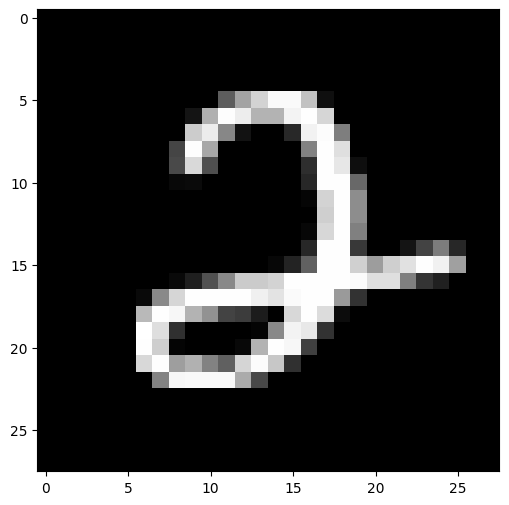

In [74]:
# exemple d'image: faire varier un peu i pour comprendre le jeu de données
i = 16
x = images[i]
p = np.reshape(images[i],(28,28))
show_mnist(p)
print(x.shape)
print(p.shape)
print(labels[i])

**QIV.1** Construire un tableau `X0` contenant $m=100$ images du chiffre zéro extraite du tableau `images`, et un tableau `X1` contenant également $m$ représentants du chiffre un également extraits de `images` (`X0` et `X1` possèderont donc $m$ lignes et $784$ colonnes). Construire ensuite les données du problème d'optimisation:
- Un tableau `X` de $n=2m$ lignes et $784$ colonnes obtenu en mettant à bout `X0` et `X1` (on pourra utiliser np.vstack). 
- Un tableau `A0` (resp. `A1`) contenant la liste des indices correspondant aux chiffres zéro (resp un).

In [79]:
ntot = len(labels)
m = 100 # nombre d'images par classe
X0 = [images[i] for i in range(ntot) if labels[i] == 0][0:m]
X1 = [images[i] for i in range(ntot) if labels[i] == 1][0:m]
X = np.vstack((X0,X1))
A0 = range(0,m)
A1 = range(m,2*m)

gamma = .1
f = lambda w: F(w,X,A0,A1,gamma)
gradf = lambda w: gradF(w,X,A0,A1,gamma)
hessf = lambda w: hessF(w,X,A0,A1,gamma)

verifier_gradient(f, gradf, x0=np.zeros(784))
verifier_hessienne(gradf, hessf, x0=np.random.rand(784))

erreur numérique dans le calcul du gradient: 2.0102e-08 (doit être petit)
erreur numerique dans le calcul de la hessienne: 7.88091e-14 (doit etre petit)


**QIV.2** Résoudre le problème d'optimisation $ \min_{w\in\Rsp^d} F(w)$ pour $\gamma=0.1$ en utilisant la méthode de Newton.

In [80]:
gamma = .1
w0 = np.zeros(784)
w,fIter,gIter = newton_armijo(lambda w: F(w,X,A0,A1,gamma),
                              lambda w: gradF(w,X,A0,A1,gamma),
                              lambda w: hessF(w,X,A0,A1,gamma),w0,
                              err=1e-8,maxiter=5000)

iteration 1: f=138.629436, |g|=377.194291, step=1.000000
iteration 2: f=25.816351, |g|=89.958706, step=1.000000
iteration 3: f=9.159966, |g|=31.569106, step=1.000000
iteration 4: f=3.712922, |g|=11.593728, step=1.000000
iteration 5: f=1.701434, |g|=4.355502, step=1.000000
iteration 6: f=0.926405, |g|=1.640519, step=1.000000
iteration 7: f=0.640555, |g|=0.598944, step=1.000000
iteration 8: f=0.557049, |g|=0.190618, step=1.000000
iteration 9: f=0.543141, |g|=0.041410, step=1.000000
iteration 10: f=0.542359, |g|=0.003433, step=1.000000
iteration 11: f=0.542354, |g|=0.000029, step=1.000000


Étant donné $ w^* \in \Rsp^{768} $ l'unique solution du problème d'optimisation, on notera $u^*: x\mapsto\sigma(\sca{x}{w^*})$. Le principe de la régression logistique (cf intro du TD) est que  $u^*(x_a) \simeq 1$ si $a \in A_0$ (c'est-à-dire si l'image $x_a$ représente le chiffre zéro) et $u^*(x_a) \simeq 0$ si $a\in A_1$ (si l'image $x_a$ représente le chiffre un). Comme on a utilisé seulement une petite fraction des images pour construire $w$ (on a choisi $n=100$ images du chiffre zéro alors que la base de données en contient $6000$!), on va maintenant chercher à valider la méthode en comparant la catégorie ($0$ où $1$) devinée par la fonction $u^*$ à celle enregistrée dans le tableau `labels` sur l'ensemble des zéros et des uns manuscrits contenus dans la base de données.

**QIV.3** Vérifier la pertinence de la méthode de la manière suivante :
- Pour chaque image MNIST $x = images[i]$ représentant un $0$ où un $1$ (pour tout $i$ tel que labels[i] $\in \{0,1\}$), calculer $u^*(x)$, et définir `label_devine`=0 si $u(x)< 1/2$ et `label_devine`=$1$ sinon.
- Comparer  label_devine au véritables label (i.e. `labels[i]`).
- Calculer enfin la proportion de cas où `label_devine=labels[i]`: ce nombre mesure la proportion de cas où la régression logistique permet de reconnaître correctement le chiffre représenté par l'image.

In [86]:
total = 0
correct = 0
for im, l in zip(images, labels):
    if l not in [0, 1]:
        continue 
    
    if((sigma(np.dot(im, w.T)) > .5) == l):
        correct += 1

    total = total+1


print(f"Pourcentage de cas ou le chiffre 0 est correctement reconnu: {100.*float(correct)/float(total) : .2f} %")

Pourcentage de cas ou le chiffre 0 est correctement reconnu:  99.64 %


**QIV.4:** Afficher le vecteur $w$ sous la forme d'une image en utilisant show_mnist(). Interpréter.

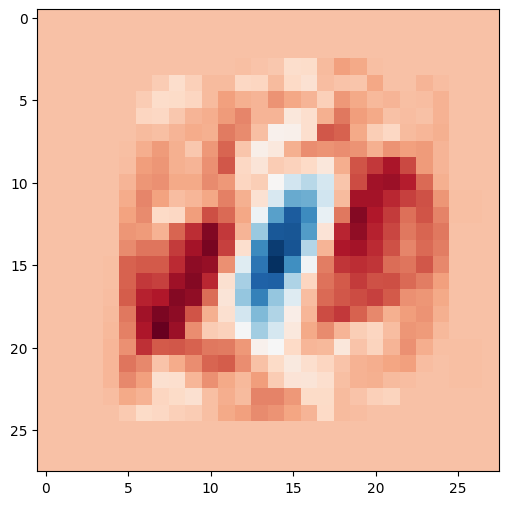

In [88]:
show_mnist(w, cmap = "RdBu")

**QIV.5** Adapter l'approche à la séparation des chiffres 0 de tout les autres chiffres. (on pourra prendre m=100 chiffres $0$ et $m$ chiffres de chaque autre classe, soit 1000 points de donnée au total).

In [91]:
train_data = {i : [] for i in range(10)}
models = {}

for im, l in zip(images, labels):
    if(len(train_data[l]) < 100):
        train_data[l].append(im)

def sep(i):
    if(i == 0):
        raise ValueError("i should be greater than 0 (found 0)")
    
    X0 = train_data[0]
    X1 = train_data[i]
    X = np.vstack((X0,X1))
    A0 = range(0,m)
    A1 = range(m,2*m)

    gamma = .1
    f = lambda w: F(w,X,A0,A1,gamma)
    gradf = lambda w: gradF(w,X,A0,A1,gamma)
    hessf = lambda w: hessF(w,X,A0,A1,gamma)

    verifier_gradient(f, gradf, x0=np.zeros(784))
    verifier_hessienne(gradf, hessf, x0=np.random.rand(784))

    gamma = .1
    w0 = np.zeros(784)
    w,fIter,gIter = newton_armijo(lambda w: F(w,X,A0,A1,gamma),
                                lambda w: gradF(w,X,A0,A1,gamma),
                                lambda w: hessF(w,X,A0,A1,gamma),w0,
                                err=1e-8,maxiter=5000)
    
    total = 0
    correct = 0
    for im, l in zip(images, labels):
        if l not in [0, 1]:
            continue 
        
        if((sigma(np.dot(im, w.T)) > .5) == l):
            correct += 1

        total = total+1


    print(f"Pourcentage de cas ou le chiffre 0 est correctement reconnu: {100.*float(correct)/float(total) : .2f} %")

    show_mnist(w, cmap = "RdBu")

erreur numérique dans le calcul du gradient: 2.41608e-08 (doit être petit)
erreur numerique dans le calcul de la hessienne: 2.23082e-16 (doit etre petit)
iteration 1: f=138.629436, |g|=270.712743, step=1.000000
iteration 2: f=26.577325, |g|=64.627249, step=1.000000
iteration 3: f=10.316764, |g|=22.851525, step=1.000000
iteration 4: f=4.886256, |g|=8.517640, step=1.000000
iteration 5: f=2.751320, |g|=3.233363, step=1.000000
iteration 6: f=1.851273, |g|=1.213661, step=1.000000
iteration 7: f=1.517483, |g|=0.422840, step=1.000000
iteration 8: f=1.434450, |g|=0.112709, step=1.000000
iteration 9: f=1.425856, |g|=0.014510, step=1.000000
iteration 10: f=1.425698, |g|=0.000394, step=1.000000
iteration 11: f=1.425697, |g|=0.000000, step=1.000000
Pourcentage de cas ou le chiffre 0 est correctement reconnu:  99.05 %


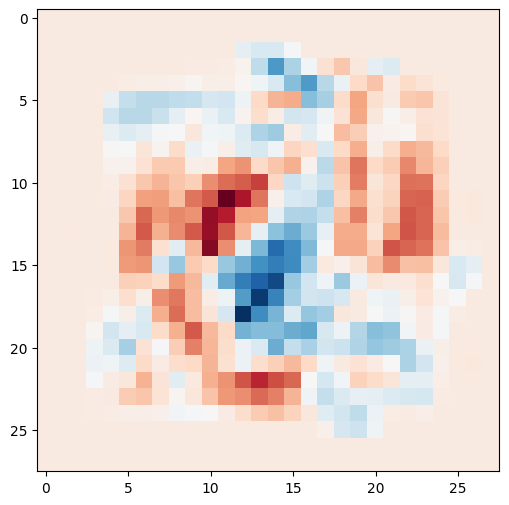

In [92]:
sep(2)

erreur numérique dans le calcul du gradient: 2.33617e-08 (doit être petit)
erreur numerique dans le calcul de la hessienne: 6.66946e-19 (doit etre petit)
iteration 1: f=138.629436, |g|=277.637946, step=1.000000
iteration 2: f=26.322919, |g|=66.269188, step=1.000000
iteration 3: f=9.874130, |g|=23.396152, step=1.000000
iteration 4: f=4.398136, |g|=8.681161, step=1.000000
iteration 5: f=2.317983, |g|=3.277148, step=1.000000
iteration 6: f=1.484415, |g|=1.233356, step=1.000000
iteration 7: f=1.177546, |g|=0.436849, step=1.000000
iteration 8: f=1.094673, |g|=0.122785, step=1.000000
iteration 9: f=1.083893, |g|=0.018205, step=1.000000
iteration 10: f=1.083605, |g|=0.000585, step=1.000000
iteration 11: f=1.083605, |g|=0.000001, step=1.000000
Pourcentage de cas ou le chiffre 0 est correctement reconnu:  99.21 %


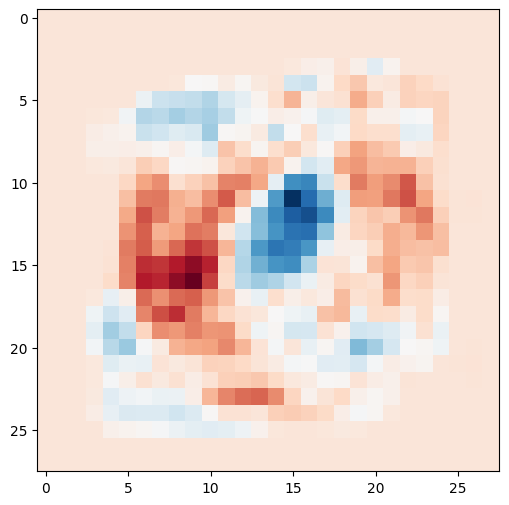

In [93]:
sep(3)

erreur numérique dans le calcul du gradient: 2.35584e-08 (doit être petit)
erreur numerique dans le calcul de la hessienne: 4.37084e-15 (doit etre petit)
iteration 1: f=138.629436, |g|=309.959959, step=1.000000
iteration 2: f=25.979998, |g|=73.933205, step=1.000000
iteration 3: f=9.410115, |g|=25.991827, step=1.000000
iteration 4: f=3.967524, |g|=9.586385, step=1.000000
iteration 5: f=1.936678, |g|=3.629609, step=1.000000
iteration 6: f=1.154508, |g|=1.374052, step=1.000000
iteration 7: f=0.875444, |g|=0.495761, step=1.000000
iteration 8: f=0.797666, |g|=0.158419, step=1.000000
iteration 9: f=0.784682, |g|=0.037019, step=1.000000
iteration 10: f=0.783953, |g|=0.003119, step=1.000000
iteration 11: f=0.783948, |g|=0.000023, step=1.000000
Pourcentage de cas ou le chiffre 0 est correctement reconnu:  87.07 %


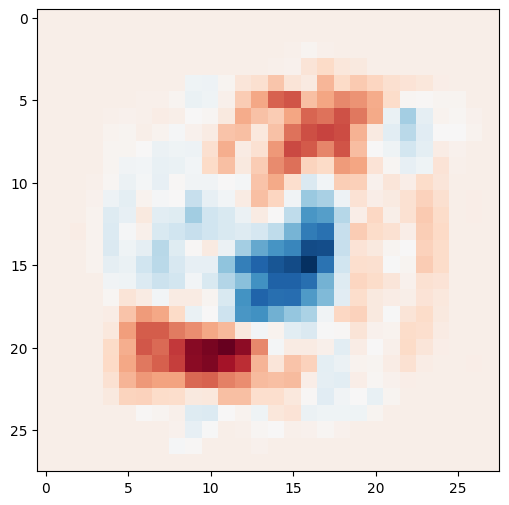

In [94]:
sep(4)

erreur numérique dans le calcul du gradient: 2.55413e-08 (doit être petit)
erreur numerique dans le calcul de la hessienne: 4.75957e-17 (doit etre petit)
iteration 1: f=138.629436, |g|=233.293946, step=1.000000
iteration 2: f=26.375012, |g|=55.660498, step=1.000000
iteration 3: f=10.042282, |g|=19.644821, step=1.000000
iteration 4: f=4.637670, |g|=7.343548, step=1.000000
iteration 5: f=2.574514, |g|=2.826267, step=1.000000
iteration 6: f=1.817704, |g|=1.095320, step=1.000000
iteration 7: f=1.573189, |g|=0.406072, step=1.000000
iteration 8: f=1.521636, |g|=0.116951, step=1.000000
iteration 9: f=1.517518, |g|=0.014990, step=1.000000
iteration 10: f=1.517457, |g|=0.000280, step=1.000000
iteration 11: f=1.517457, |g|=0.000000, step=1.000000
Pourcentage de cas ou le chiffre 0 est correctement reconnu:  98.69 %


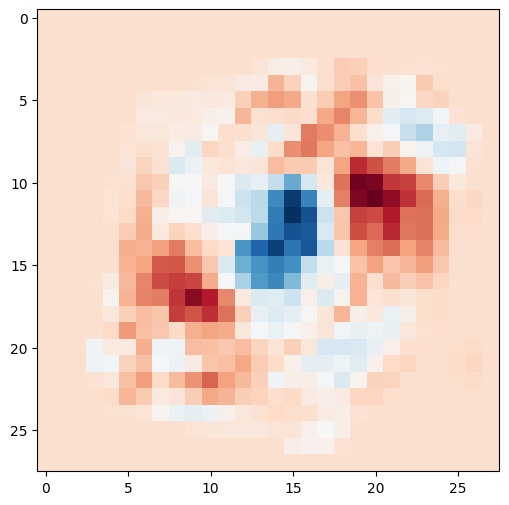

In [95]:
sep(5)

erreur numérique dans le calcul du gradient: 2.24949e-08 (doit être petit)
erreur numerique dans le calcul de la hessienne: 3.23325e-14 (doit etre petit)
iteration 1: f=138.629436, |g|=292.912608, step=1.000000
iteration 2: f=26.572878, |g|=69.943533, step=1.000000
iteration 3: f=10.203532, |g|=24.715813, step=1.000000
iteration 4: f=4.708909, |g|=9.222362, step=1.000000
iteration 5: f=2.499296, |g|=3.532777, step=1.000000
iteration 6: f=1.607921, |g|=1.349802, step=1.000000
iteration 7: f=1.273264, |g|=0.500214, step=1.000000
iteration 8: f=1.176491, |g|=0.149056, step=1.000000
iteration 9: f=1.165128, |g|=0.026198, step=1.000000
iteration 10: f=1.164785, |g|=0.001375, step=1.000000
iteration 11: f=1.164784, |g|=0.000004, step=1.000000
Pourcentage de cas ou le chiffre 0 est correctement reconnu:  98.34 %


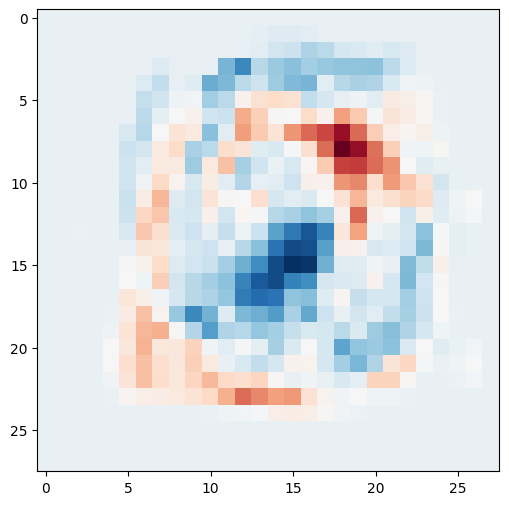

In [96]:
sep(6)

erreur numérique dans le calcul du gradient: 2.33194e-08 (doit être petit)
erreur numerique dans le calcul de la hessienne: 3.07662e-15 (doit etre petit)
iteration 1: f=138.629436, |g|=319.619815, step=1.000000
iteration 2: f=26.225445, |g|=76.255176, step=1.000000
iteration 3: f=9.804145, |g|=26.875483, step=1.000000
iteration 4: f=4.366666, |g|=10.024578, step=1.000000
iteration 5: f=2.240269, |g|=3.877990, step=1.000000
iteration 6: f=1.354278, |g|=1.504602, step=1.000000
iteration 7: f=1.013889, |g|=0.544148, step=1.000000
iteration 8: f=0.915125, |g|=0.166386, step=1.000000
iteration 9: f=0.899560, |g|=0.032564, step=1.000000
iteration 10: f=0.898939, |g|=0.001993, step=1.000000
iteration 11: f=0.898937, |g|=0.000008, step=1.000000
Pourcentage de cas ou le chiffre 0 est correctement reconnu:  96.87 %


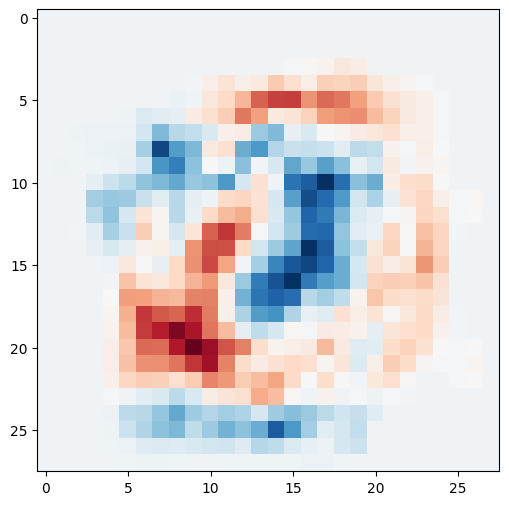

In [97]:
sep(7)

erreur numérique dans le calcul du gradient: 2.24437e-08 (doit être petit)
erreur numerique dans le calcul de la hessienne: 7.65412e-17 (doit etre petit)
iteration 1: f=138.629436, |g|=298.540730, step=1.000000
iteration 2: f=25.996811, |g|=71.216628, step=1.000000
iteration 3: f=9.429466, |g|=25.041580, step=1.000000
iteration 4: f=4.005688, |g|=9.231681, step=1.000000
iteration 5: f=2.004719, |g|=3.494380, step=1.000000
iteration 6: f=1.225554, |g|=1.335551, step=1.000000
iteration 7: f=0.930206, |g|=0.490605, step=1.000000
iteration 8: f=0.842100, |g|=0.152653, step=1.000000
iteration 9: f=0.828096, |g|=0.030699, step=1.000000
iteration 10: f=0.827492, |g|=0.002112, step=1.000000
iteration 11: f=0.827490, |g|=0.000012, step=1.000000
Pourcentage de cas ou le chiffre 0 est correctement reconnu:  99.30 %


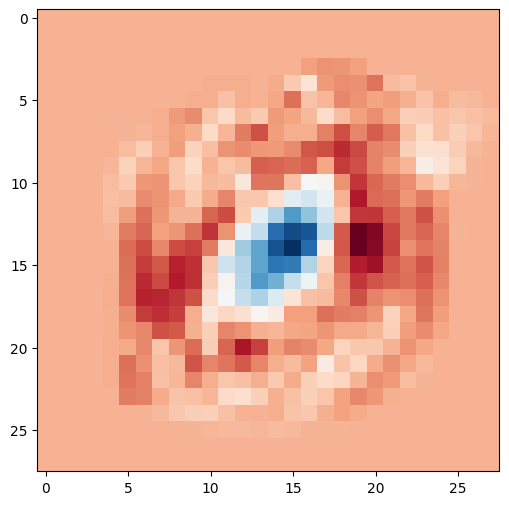

In [98]:
sep(8)

erreur numérique dans le calcul du gradient: 2.30439e-08 (doit être petit)
erreur numerique dans le calcul de la hessienne: 9.00093e-17 (doit etre petit)
iteration 1: f=138.629436, |g|=314.801124, step=1.000000
iteration 2: f=26.346821, |g|=75.080204, step=1.000000
iteration 3: f=9.972032, |g|=26.376883, step=1.000000
iteration 4: f=4.553935, |g|=9.725274, step=1.000000
iteration 5: f=2.476371, |g|=3.669112, step=1.000000
iteration 6: f=1.674586, |g|=1.367526, step=1.000000
iteration 7: f=1.394922, |g|=0.467765, step=1.000000
iteration 8: f=1.324231, |g|=0.120872, step=1.000000
iteration 9: f=1.316658, |g|=0.014491, step=1.000000
iteration 10: f=1.316531, |g|=0.000275, step=1.000000
iteration 11: f=1.316531, |g|=0.000000, step=1.000000
Pourcentage de cas ou le chiffre 0 est correctement reconnu:  98.43 %


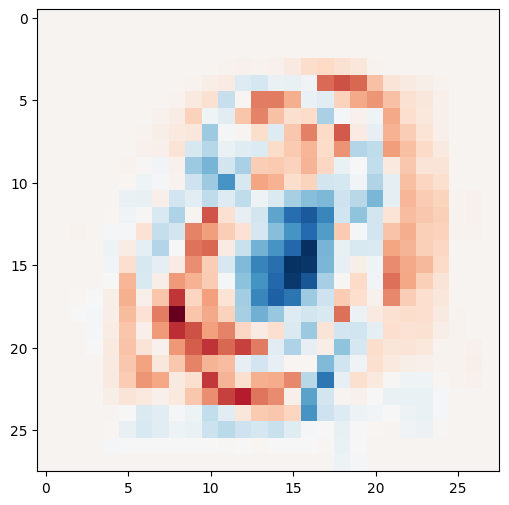

In [99]:
sep(9)